# Multiple Hobo analysis

## Import packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
import pandas as pd
import os

## Function - get_time_column

In [4]:
def get_time_column(columns):
    """Returns the time column from a list of Hobo headers
    
    Arguments:
        - columns (str): list of column names
        
    Returns
        - str: the time column name
    
    """
    return columns[1]

In [3]:
get_time_column(["#","Date Time, GMT+00:00","Temp, °F (LGR S/N: 10469238, SEN S/N: 10469238)",
                 "Coupler Attached (LGR S/N: 10469238)","Host Connected (LGR S/N: 10469238)",
                 "Stopped (LGR S/N: 10469238)","End Of File (LGR S/N: 10469238)"])

'Date Time, GMT+00:00'

## Function - decompose_column_name

In [37]:
def decompose_column_name(col_name):
    """Returns separate parts of a hobo column name
    
    Argument:
        - col_name (str): the column name
        
    Returns:
        - tuple: (variable_name, unit_name, serial_text)
    
    """
    
    x=col_name.split('(')
    
    try:
        serial_text=x[1].split(')')[0].strip()
    except IndexError:
        serial_text=None    
    
    y=x[0].split(',')
    variable_name=y[0].strip()
    
    if len(y)>1:
        unit_name=y[1].strip()
    else:
        unit_name=None
    
    return variable_name,unit_name,serial_text

In [38]:
decompose_column_name('Temp, °F (LGR S/N: 10469238, SEN S/N: 10469238)')

('Temp', '°F', 'LGR S/N: 10469238, SEN S/N: 10469238')

In [39]:
decompose_column_name('Coupler Attached (LGR S/N: 10469238)')

('Coupler Attached', None, 'LGR S/N: 10469238')

In [40]:
decompose_column_name('#')

('#', None, None)

## Function - read_hobo_file

In [105]:
def read_hobo_file(filename,convert_to_farenheit=False):
    """
    
    Arguments:
        - filename (str): the name of the hobo file
        
    Returns:
        - pd.DataFrame
    
    """
    
    print(filename)
    
    # find the time column
    df=pd.read_csv(filename,skiprows=1)
    time_zone=get_time_column(df.columns)
    
    # read in the csv
    df=pd.read_csv(filename,skiprows=1,parse_dates=[time_zone])
    
    # set the index as the time column
    df=df.set_index(time_zone)
    
    # rename columns
    columns=[decompose_column_name(x) for x in df.columns]
    df.columns=pd.MultiIndex.from_tuples(columns)
    
    df.columns=df.columns.set_names(['variable_name','units','serial_text'])
    
    # convert temperatures to farenheit
    if convert_to_farenheit:
        try:
            df1=df['Temp']['°F']
            for col in df1.columns:
                df=farenheit_to_centigrade(df,('Temp','°F',col))
        except KeyError:
            pass
    
    return df

In [103]:
df=read_hobo_file('sensor1_ben.csv',convert_to_farenheit=True)
df.head()

sensor1_ben.csv
LGR S/N: 10469238, SEN S/N: 10469238


variable_name,#,Temp,Coupler Attached,Host Connected,Stopped,End Of File,Temp
units,NaN,°F,NaN,NaN,NaN,NaN,°C
serial_text,NaN,"LGR S/N: 10469238, SEN S/N: 10469238",LGR S/N: 10469238,LGR S/N: 10469238,LGR S/N: 10469238,LGR S/N: 10469238,"LGR S/N: 10469238, SEN S/N: 10469238"
"Date Time, GMT+00:00",,,,,,,
2014-03-31 07:00:00,1,69.622,NaN,NaN,NaN,NaN,20.901111
2014-03-31 07:30:00,2,69.622,NaN,NaN,NaN,NaN,20.901111
2014-03-31 08:00:00,3,69.449,NaN,NaN,NaN,NaN,20.805000
2014-03-31 08:30:00,4,69.622,NaN,NaN,NaN,NaN,20.901111
2014-03-31 09:00:00,5,69.964,NaN,NaN,NaN,NaN,21.091111


## Function farenheit to centigrade

In [68]:
def farenheit_to_centigrade(df,column_name):
    """Converts the data in column_name from F to C
    
    Arguments
        - df (pd.Dataframe)
        - column_name (str)
        
    returns
        - (pd.Dataframe) - the updated dataframe
    
    """
    
    if column_name[1]!='°F':
        raise Exception('The units are not farenheit')
    
    df[column_name[0],'°C',column_name[2]]=(df[tuple(column_name)]-32)*5/9
    
    
    return df

In [72]:
df=farenheit_to_centigrade(df,['Temp','°F','LGR S/N: 10469238, SEN S/N: 10469238'])
df.head()

variable_name,#,Temp,Coupler Attached,Host Connected,Stopped,End Of File,Temp
units,NaN,°F,NaN,NaN,NaN,NaN,°C
serial_text,NaN,"LGR S/N: 10469238, SEN S/N: 10469238",LGR S/N: 10469238,LGR S/N: 10469238,LGR S/N: 10469238,LGR S/N: 10469238,"LGR S/N: 10469238, SEN S/N: 10469238"
"Date Time, GMT+00:00",,,,,,,
2014-03-31 07:00:00,1,69.622,NaN,NaN,NaN,NaN,20.901111
2014-03-31 07:30:00,2,69.622,NaN,NaN,NaN,NaN,20.901111
2014-03-31 08:00:00,3,69.449,NaN,NaN,NaN,NaN,20.805000
2014-03-31 08:30:00,4,69.622,NaN,NaN,NaN,NaN,20.901111
2014-03-31 09:00:00,5,69.964,NaN,NaN,NaN,NaN,21.091111


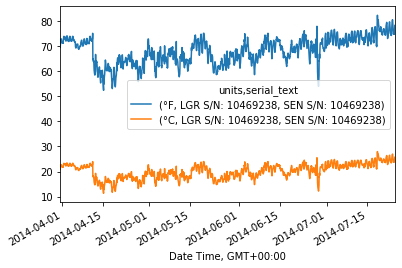

In [76]:
df['Temp'].plot()

# Multiple files

## Import raw data

In [106]:
hobofile_dict={}

for filename in os.listdir():
    
    if filename.endswith('.csv'):
        
        df=read_hobo_file(filename,convert_to_farenheit=True)       
        
        hobofile_dict[filename]=df
        
#raw_data_dict

Correct.csv
Sensor1.csv
sensor1_ben.csv
Sensor2.csv


In [107]:
len(hobofile_dict)

4

In [108]:
hobofile_dict.keys()

dict_keys(['Correct.csv', 'Sensor1.csv', 'sensor1_ben.csv', 'Sensor2.csv'])

In [109]:
hobofile_dict['Sensor1.csv'].head()

variable_name,#,Temp,Coupler Attached,Host Connected,Stopped,End Of File,Temp
units,NaN,°F,NaN,NaN,NaN,NaN,°C
serial_text,NaN,"LGR S/N: 10456880, SEN S/N: 10456880",LGR S/N: 10456880,LGR S/N: 10456880,LGR S/N: 10456880,LGR S/N: 10456880,"LGR S/N: 10456880, SEN S/N: 10456880"
"Date Time, GMT+01:00",,,,,,,
2019-10-10 12:00:00,1,70.651,NaN,NaN,NaN,NaN,21.472778
2019-10-10 12:05:00,2,71.168,NaN,NaN,NaN,NaN,21.760000
2019-10-10 12:10:00,3,71.856,NaN,NaN,NaN,NaN,22.142222
2019-10-10 12:15:00,4,72.372,NaN,NaN,NaN,NaN,22.428889
2019-10-10 12:20:00,5,72.718,NaN,NaN,NaN,NaN,22.621111


In [113]:
for k,v in hobofile_dict.items():
    v.to_csv('NEW'+k)

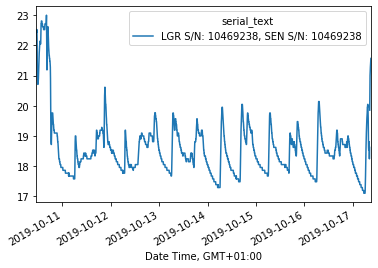

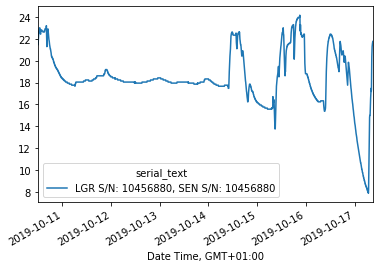

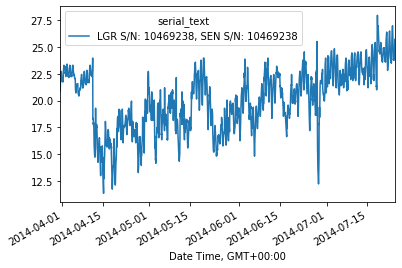

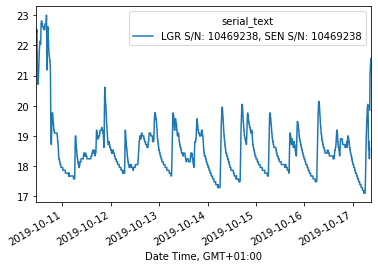

In [111]:
for k,v in hobofile_dict.items():
    v['Temp']['°C'].plot()

PLOT_FILENAME: test.png


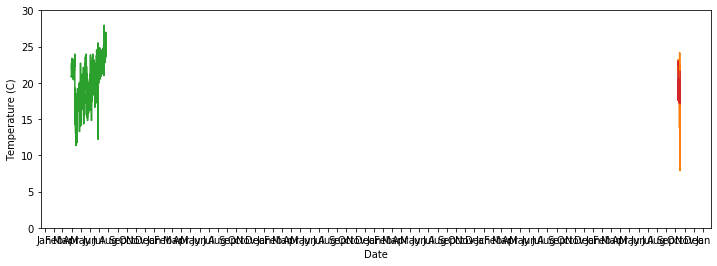

In [112]:
register_matplotlib_converters()
fig, ax = plt.subplots(1,figsize=(12,4))
for k,df in hobofile_dict.items():
    ax.plot(df['Temp']['°C'])#,color='black',linewidth=0.5)
ax.set_xlabel('Date')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_ylim([0,30])
ax.set_ylabel('Temperature (C)')
plot_filename=r'test.png'
print('PLOT_FILENAME: '+plot_filename)
plt.savefig(plot_filename, bbox_inches='tight')
plt.show()

## Clean up data

In [70]:
clean_data_dict={}

for filename,df in raw_data_dict.items():

    time_col=df.columns[1]
    #print(df.columns)
    data_col=[x for x in df.columns if x.startswith('Temp')][0]
    df1=df[[time_col,data_col]].copy()
    df1=df1.rename(columns={time_col:'DateTime',
                            data_col:'Temp'})
    df1=df1.dropna()
    
    if '°F' in data_col:
        df1['Temp']=(df1['Temp']-32)*5/9

    df1=df1.set_index('DateTime')

    clean_data_dict[filename]=df1

clean_data_dict['Correct.csv']

,Temp
DateTime,
2019-10-10 11:00:00,22.333
2019-10-10 11:05:00,22.525
2019-10-10 11:10:00,22.429
2019-10-10 11:15:00,22.525
2019-10-10 11:20:00,22.525
2019-10-10 11:25:00,22.238
2019-10-10 11:30:00,21.378
2019-10-10 11:35:00,20.996
2019-10-10 11:40:00,20.805


In [ ]:
df1['Temp']=(df1['Temp']-32)*5/9
df1=df1.set_index('DateTime')

In [42]:
l=[0,1,2]
l[1]

1

In [43]:
d={'item1':1,'item2':2}

In [44]:
d

{'item1': 1, 'item2': 2}

In [45]:
d['item2']

2

In [46]:
d['item44']=10

In [47]:
d

{'item1': 1, 'item2': 2, 'item44': 10}

In [48]:
for k,v in d.items():
    print(k,v)

item1 1
item2 2
item44 10


In [35]:
len(l)

4

In [37]:
l[1]

,#,"Date Time, GMT+01:00","Temp, °F (LGR S/N: 10456880, SEN S/N: 10456880)",Coupler Attached (LGR S/N: 10456880),Host Connected (LGR S/N: 10456880),Stopped (LGR S/N: 10456880),End Of File (LGR S/N: 10456880)
0,1,2019-10-10 12:00:00,70.651,NaN,NaN,NaN,NaN
1,2,2019-10-10 12:05:00,71.168,NaN,NaN,NaN,NaN
2,3,2019-10-10 12:10:00,71.856,NaN,NaN,NaN,NaN
3,4,2019-10-10 12:15:00,72.372,NaN,NaN,NaN,NaN
4,5,2019-10-10 12:20:00,72.718,NaN,NaN,NaN,NaN
5,6,2019-10-10 12:25:00,72.891,NaN,NaN,NaN,NaN
6,7,2019-10-10 12:30:00,73.062,NaN,NaN,NaN,NaN
7,8,2019-10-10 12:35:00,73.234,NaN,NaN,NaN,NaN
8,9,2019-10-10 12:40:00,73.234,NaN,NaN,NaN,NaN
9,10,2019-10-10 12:45:00,73.407,NaN,NaN,NaN,NaN


In [9]:
if 1>2:
    print('true')
else:
    print('false')

false


In [2]:
import os

for filename in os.listdir():
    
    print(filename)
    
    continue
    
    
    if filename.endswith(".asm") or filename.endswith(".py"): 
         # print(os.path.join(directory, filename))
        continue
    else:
        continue

.ipynb_checkpoints
Correct.csv
MultipleHoboAnalysis.ipynb
Sensor1.csv
sensor1_ben.csv
Sensor2.csv
